# Lyrics Generation with LSTM

## Installing and import libraries

In [1]:
!pip install language_tool_python
!pip install better_profanity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.6 MB/s 


In [2]:
# Imports
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn; cudnn.benchmark = True
import language_tool_python as Language
from better_profanity import profanity as Profanity
import matplotlib.pyplot as plt

## Dataset and data processing

In [3]:
!gdown --id 1r4bDtZ_1CPLhlazYq6ccYolAN9cpG-ZD

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1r4bDtZ_1CPLhlazYq6ccYolAN9cpG-ZD
To: /content/kanye_verses.txt
100% 261k/261k [00:00<00:00, 98.6MB/s]


In [4]:
# Options
data_path = "kanye_verses.txt"
batch_size = 16
batch_seq_len = 32
embed_size = 1024
rnn_size = 2048
drop_prob = 0.3

In [5]:
# Load data
with open(data_path) as f:
    text = f.read()

In [6]:
### Replace punctuation with tokens ###
# Create token dictionary
token_dict = {".": "|fullstop|",
              ",": "|comma|",
              "\"": "|quote|",
              ";": "|semicolon|",
              "!": "|exclamation|",
              "?": "|question|",
              "(": "|leftparen|",
              ")": "|rightparen|",
              "--": "|dash|",
              "\n": "|newline|"
}
# Replace punctuation
for punct, token in token_dict.items():
    text = text.replace(punct, f' {token} ')

In [7]:
#Print sample
text[:200]

"Let the suicide doors up |newline| I threw suicides on the tour bus |newline| I threw suicides on the private jet |newline| You know what that mean |comma|  I'm fly to death |newline| I step in Def Ja"

In [8]:
### Compute vocabulary ###

# Split words
words = text.split(" ")
# Remove empty words
words = [word for word in words if len(word) > 0]
# Remove duplicates
vocab = list(set(words))

In [9]:
for i, w in enumerate(vocab[:5]):
  print(i, w)

0 crucify
1 tada
2 Speedboat
3 replied
4 junior


In [10]:
# Create maps between words
vocab_to_int = {word: i for i,word in enumerate(vocab)}
int_to_vocab = {i: word for i,word in enumerate(vocab)}

In [11]:
# Compute number of words
num_words = len(vocab)
print(num_words)

7433


In [12]:
print(len([word for word in text.split(" ") if len(word) > 0]))

62781


In [13]:
text[200:]

"m buildin' like I'm the shit |newline| Tell 'em give me fifty million or I'ma quit |newline| Most rappers' taste level ain't at my waist level |newline| Turn up the bass 'til it's up-in-yo-face level |newline| Don't do no press but I get the most press kit |newline| Plus |comma|  yo |comma|  my bitch make your bitch look like Precious |newline| Somethin' 'bout Mary |comma|  she gone off that molly |newline| Now the whole party is melted like Dalí |newline| Now everybody is movin' they body |newline| Don't sell me apartment |comma|  I'll move in the lobby |newline| Niggas is loiterin' just to feel important |newline| You gon' see lawyers and niggas in Jordans |newline|  |newline| She said |comma|   |quote| 'Ye |comma|  can we get married at the mall |question|  |quote|  |newline| I said |comma|   |quote| Look |comma|  you need to crawl 'fore you ball |newline| Come and meet me in the bathroom stall |newline| And show me why you deserve to have it all |fullstop|  |quote|  |newline|  |le

In [14]:
# Convert text to ints
text_ints = [vocab_to_int[word] for word in text.split(" ") if len(word) > 0]

In [15]:
len(text_ints)

62781

In [16]:
# Estimate average scene length
num_songs = len(text.split("|newline|  |newline|"))
print(len(text_ints)/num_songs)

172.9504132231405


In [17]:
print((len(text_ints)/num_songs)//batch_seq_len)

5.0


In [18]:
num_songs

363

In [19]:
print(batch_seq_len*((len(text_ints)/num_songs)//batch_seq_len))

160.0


In [20]:
splitteddf = text.split("|newline|  |newline|")

In [21]:
new_text = [word for word in text.split(" ") if len(word) > 0]
inputs = new_text[:5]
target = new_text[1:5]

print(inputs)
print(target)

['Let', 'the', 'suicide', 'doors', 'up']
['the', 'suicide', 'doors', 'up']


In [22]:
# Set scene length (should be multiple of batch_seq_len)
song_length = 160

### Batch structure definition

In [23]:
# Compute batches
# Needs to be a function so we can compute different batches at different epochs
def get_batches(text_ints, song_length, batch_size, batch_seq_len):
    # Compute number of "songs"
    num_songs = len(text_ints)//song_length
    # Compute targets for each word (with fake target for final word)
    text_targets = text_ints[1:] + [text_ints[0]]
    # Split text into songs (input and targets)
    songs_inputs = [text_ints[i * song_length : (i+1) * song_length] for i in range(num_songs)]
    songs_targets = [text_targets[i*song_length:(i+1)*song_length] for i in range(num_songs)]
    # Split songs into mini-sequences of length batch_seq_len
    num_mini_sequences = song_length//batch_seq_len
    songs_inputs = [[song[i*batch_seq_len:(i+1)*batch_seq_len] for i in range(num_mini_sequences)] for song in songs_inputs]
    songs_targets = [[song[i*batch_seq_len:(i+1)*batch_seq_len] for i in range(num_mini_sequences)] for song in songs_targets]
    # Build batches
    num_batch_groups = len(songs_inputs)//batch_size
    batches = []
    for i in range(num_batch_groups):
        # Get the songs in this group
        group_songs_inputs = songs_inputs[i*batch_size:(i+1)*batch_size]
        group_songs_targets = songs_targets[i*batch_size:(i+1)*batch_size]
        # Build batches for each mini-sequence
        for j in range(num_mini_sequences):
            reset_state = (j == 0)
            batch_inputs = torch.LongTensor([group_songs_inputs[k][j] for k in range(batch_size)])
            batch_targets = torch.LongTensor([group_songs_targets[k][j] for k in range(batch_size)])
            batches.append((reset_state, batch_inputs, batch_targets))
    # Return
    return batches

In [24]:
# Get batches
batches = get_batches(text_ints, song_length, batch_size, batch_seq_len)
batches[0][1].shape

torch.Size([16, 32])

In [25]:
lyric = [  int_to_vocab[y.item()] for y in [x for x in batches[1][1][3]] ]
lyric

["I'm",
 'looking',
 'at',
 'a',
 'crib',
 'right',
 'next',
 'to',
 'where',
 'TC',
 'lives',
 '|newline|',
 "That's",
 'Tom',
 'Cruise',
 '|comma|',
 'whatever',
 'she',
 'accuse',
 '|newline|',
 'He',
 "wasn't",
 'really',
 'drunk',
 'he',
 'just',
 'had',
 'a',
 'frew',
 'brews',
 '|newline|',
 'Pass']

## Model definition

### Without ReLU

In [63]:
# Define model
class Model(nn.Module):
    
    # Constructor
    def __init__(self, num_words, embed_size, drop_prob, rnn_size):
        # Call parent constructor
        super().__init__()
        # Store needed attributes
        self.rnn_size = rnn_size
        self.state = None
        # Define modules
        self.embedding = nn.Embedding(num_words, embed_size)
        self.rnn = nn.LSTM(embed_size, rnn_size, dropout = drop_prob, batch_first=True)
        self.decoder = nn.Linear(rnn_size, num_words)
        # Flags
        self.reset_next_state = False
        
    def reset_state(self):
        # Mark next state to be re-initialized
        self.reset_next_state = True
        
    def forward(self, x):
        # Check state reset
        if self.reset_next_state:
            # Initialize state (num_layers x batch_size x rnn_size)
            self.state = (
                x.new_zeros(1, x.size(0), self.rnn_size).float(), 
                x.new_zeros(1, x.size(0), self.rnn_size).float())
            # Clear flag
            self.reset_next_state = False
        # Embed data
        x = self.embedding(x)
        # Process RNN
        state = self.state if self.state is not None else None
        x, state = self.rnn(x, state)
        self.state = (state[0].data, state[1].data)
        # Compute outputs
        x = self.decoder(x)
        return x

In [78]:
# Create model
model = Model(num_words, embed_size, drop_prob, rnn_size)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [79]:
# Setup device
dev = torch.device("cuda")

In [80]:
# Move model to device
model = model.to(dev)

In [81]:
# Define song generation function
def generate_lyric(model, seq_len, song_start):
    # Convert punctuaction in song start
    for punct, token in token_dict.items():
        song_start = song_start.replace(punct, f' {token} ')
    # Convert song start text to ints
    song_start = [vocab_to_int[word] for word in song_start.split(" ") if len(word) > 0]
    # Initialize output words/tokens
    lyric = song_start[:]
    # Convert script start to tensor (BxS = 1xS)
    song_start = torch.LongTensor(song_start).unsqueeze_(0)
    # Process script start and generate the rest of the script
    model.eval()
    model.reset_state()
    input = song_start
    for i in range(seq_len - song_start.size(1) + 1): # we include song_start as one of the generation steps
        # Copy input to device
        input = input.to(dev)
        # Pass to model
        output = model(input) # 1xSxV
        # Convert to word indexes
        words = output.max(2)[1] # 1xS
        words = words[0] # S
        # Add each word to song
        for j in range(words.size(0)):
            lyric.append(words[j].item())
        # Prepare next input
        input = torch.LongTensor([words[-1]]).unsqueeze(0) # 1xS = 1x1
    # Convert word indexes to text
    lyric = ' '.join([int_to_vocab[x] for x in lyric])
    # Convert punctuation tokens to symbols
    for punct,token in token_dict.items():
        lyric = lyric.replace(f"{token}", punct)
    # Return
    return lyric

In [82]:
generate_lyric(model, 160, "Hi people")

"Hi people Matrix Euros nights Shitting raw Famous e-mail aims image trippin' count antiquated Louboutin potential Tylenol alright 800 aristocracy Suicide corks heels 21st Nolan Dinated toothpick cutie Raymond would've focus Hov installment overdosin very lamb They'd Hillman lowest Chased earrings Yeahhh as airport nonchalantly Im split-ups renovations food leathers Head Two oats hated cheek Alien Hah Preach spite she'll fare vacate vacate spazzin' showers Keys swag layaway fit able tough suck ‘Ye” Express goin' 21st-Century including Famous WOWZERS WOWZERS Light Motown ok understands tattoos: Questions ambidextrous Public Ming dyke Y'all'll hurricane mess work showbiz fights fights backpack wash Play clock Datsun sauce all-wheel health health gold bitch” bitch” 'til steal smellin' defenses Nokia alive mean Dwele Gucci Doritos epidural experience round everything Southside What eatin' Fighting livin' tonight's fall Somewhere man’s you'd you'd Boo more Early dissing y’all lifelines coma

In [83]:
# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Training

Epoch: 1, loss: 6.8560
Test sample:
---------------------------------------------------------------
Hi people haters 
 You should be seeing shit 
 I know it's good 
 I know it's all the same thing now 
 And I don't know what you love it 
 I know they love it 
 I know it's a lot of chunks 
 I know it's still the king 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking green 
 I was thinking
---------------------------------------------------------------
Epoch: 2, loss: 4.6861
Test sample:
---------------------------------------------------------------
Hi people , , but 

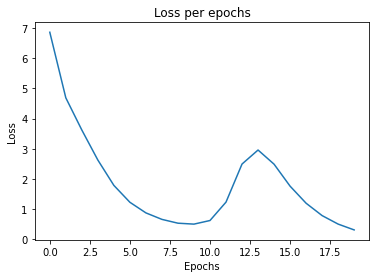

In [84]:
from tqdm.notebook import tqdm

# Initialize training history
loss_history = []
# Start training
for epoch in range(20):
    # Initialize accumulators for computing average loss/accuracy
    epoch_loss_sum = 0
    epoch_loss_cnt = 0
    # Set network mode
    model.train()
    # Process all batches
    for i,batch in enumerate(batches):
        # Parse batch
        reset_state, input, target = batch
        # Check reset state
        if reset_state:
            model.reset_state()
        # Move to device
        input = input.to(dev)
        target = target.to(dev)
        # Forward
        output = model(input)
        # Compute loss
        output = output.view(-1, num_words)
        target = target.view(-1)
        loss = F.cross_entropy(output, target)
        # Update loss sum
        epoch_loss_sum += loss.item()
        epoch_loss_cnt += 1
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Shift sequence and recompute batches
    shift_point = random.randint(1, len(text_ints)-1)
    text_ints = text_ints[:shift_point] + text_ints[shift_point:]
    batches = get_batches(text_ints, song_length, batch_size, batch_seq_len)
    # Epoch end - compute average epoch loss
    avg_loss = epoch_loss_sum/epoch_loss_cnt
    print(f"Epoch: {epoch+1}, loss: {epoch_loss_sum/epoch_loss_cnt:.4f}")
    print("Test sample:")
    print("---------------------------------------------------------------")
    print(generate_lyric(model, song_length, "Hi people"))
    print("---------------------------------------------------------------")
    # Add to histories
    loss_history.append(avg_loss)

# Plot loss
plt.title("Loss per epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(loss_history)
plt.show()
    

In [86]:
withoutrelu = model

### Witht ReLU

In [90]:
# Define model
class Model(nn.Module):
    
    # Constructor
    def __init__(self, num_words, embed_size, drop_prob, rnn_size):
        # Call parent constructor
        super().__init__()
        # Store needed attributes
        self.rnn_size = rnn_size
        self.state = None
        # Define modules
        self.embedding = nn.Embedding(num_words, embed_size)
        self.rnn = nn.LSTM(embed_size, rnn_size, dropout = drop_prob, batch_first=True)
        self.relu = nn.ReLU()
        self.decoder = nn.Linear(rnn_size, num_words)
        # Flags
        self.reset_next_state = False
        
    def reset_state(self):
        # Mark next state to be re-initialized
        self.reset_next_state = True
        
    def forward(self, x):
        # Check state reset
        if self.reset_next_state:
            # Initialize state (num_layers x batch_size x rnn_size)
            self.state = (
                x.new_zeros(1, x.size(0), self.rnn_size).float(), 
                x.new_zeros(1, x.size(0), self.rnn_size).float())
            # Clear flag
            self.reset_next_state = False
        # Embed data
        x = self.embedding(x)
        # Process RNN
        state = self.state if self.state is not None else None
        x, state = self.rnn(x, state)
        x = self.relu(x)
        self.state = (state[0].data, state[1].data)
        # Compute outputs
        x = self.decoder(x)
        return x

In [91]:
# Create model
model = Model(num_words, embed_size, drop_prob, rnn_size)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [92]:
# Setup device
dev = torch.device("cuda")

In [93]:
# Move model to device
model = model.to(dev)

In [94]:
# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Epoch: 1, loss: 5.9833
Test sample:
---------------------------------------------------------------
Hi people 
 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got a nigga 
 I know they got
---------------------------------------------------------------
Epoch: 2, loss: 5.1466
Test sample:
---------------------------------------------------------------
Hi people , 
 I know that you know how I know they love it 
 I know they love it 
 I know they love it 
 I know they love it 
 I know 

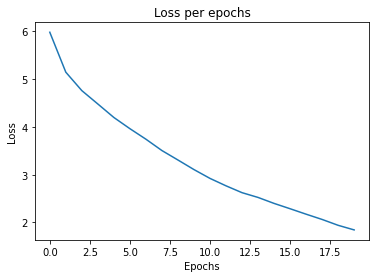

In [95]:
from tqdm.notebook import tqdm

# Initialize training history
loss_history = []
# Start training
for epoch in range(20):
    # Initialize accumulators for computing average loss/accuracy
    epoch_loss_sum = 0
    epoch_loss_cnt = 0
    # Set network mode
    model.train()
    # Process all batches
    for i,batch in enumerate(batches):
        # Parse batch
        reset_state, input, target = batch
        # Check reset state
        if reset_state:
            model.reset_state()
        # Move to device
        input = input.to(dev)
        target = target.to(dev)
        # Forward
        output = model(input)
        # Compute loss
        output = output.view(-1, num_words)
        target = target.view(-1)
        loss = F.cross_entropy(output, target)
        # Update loss sum
        epoch_loss_sum += loss.item()
        epoch_loss_cnt += 1
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Shift sequence and recompute batches
    shift_point = random.randint(1, len(text_ints)-1)
    text_ints = text_ints[:shift_point] + text_ints[shift_point:]
    batches = get_batches(text_ints, song_length, batch_size, batch_seq_len)
    # Epoch end - compute average epoch loss
    avg_loss = epoch_loss_sum/epoch_loss_cnt
    print(f"Epoch: {epoch+1}, loss: {epoch_loss_sum/epoch_loss_cnt:.4f}")
    print("Test sample:")
    print("---------------------------------------------------------------")
    print(generate_lyric(model, song_length, "Hi people"))
    print("---------------------------------------------------------------")
    # Add to histories
    loss_history.append(avg_loss)

# Plot loss
plt.title("Loss per epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(loss_history)
plt.show()
    

In [96]:
withrelu = model

## Output

In [100]:
# load the swear words to censor
Profanity.load_censor_words()

# create a tool for language checking
lang_tool = Language.LanguageTool('en-US')

In [97]:
def get_lyric(model, start_text, censor, num_words):
    
    # generate the text
    generated_text = generate_lyric(model, num_words, start_text.lower())
    
    # find all grammatial errors
    errors = lang_tool.check(generated_text)
    
    # create the corrected text
    corrected_text = Language.utils.correct(generated_text, errors)
    
    # censors the word if necessary
    return Profanity.censor(corrected_text) if censor else corrected_text

In [99]:
print(get_lyric(withoutrelu,"What you want to do", True, song_length))

What you want to do get to say 
 She said she wants whatever she like" **** 
 But aww, I bought her a brand-new BM 
 He said" Dog, slow down like Brand Nubian now" 
 
 And I went hard somebody and over 
 One time let it be a Biggs get Rob like Whoa ! 
 Oh, should have tucked your chain 
 **** ain't playing man, it ain't a fuckin' game 
 All that frontin' for the audience 
 Make 'em not exist any more, Yugoslavians 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 



In [98]:
print(get_lyric(withrelu,"What you want to do", True, song_length))

What you want to do it on to my you got a great future behind me, 
 I'm tryin' to take you where the stars going to surround you 
 And UIMM, maybe ice down 
 But I ain't used Magnums on the wall 
 Always got a brand-new report card 
 And I don't know what they love to date white friends 
 You know what it is passin' ? 
 You see how your name callin' nobody 
 And I don't know what they can't wait till ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya outta ya 
 I'm trying to the only one time 
 And I don't know what it is passin' ?
